# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [5]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [6]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [7]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [8]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

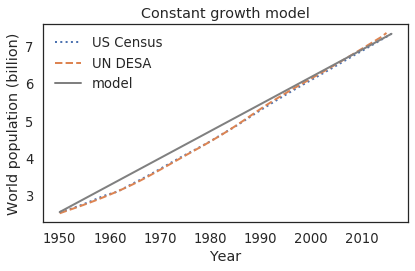

In [9]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [10]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [11]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file figs/chap06-fig01.pdf


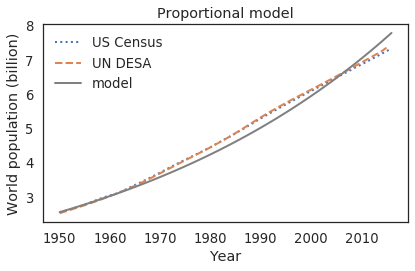

In [12]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [13]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print(t, pop)
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [14]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [15]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [16]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [17]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]
# Allen should initialize these here, too.
birth_rate = 0.027
death_rate=0.01

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=birth_rate,
                death_rate=death_rate)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


1950 2.557628654
1951 2.601108341118
1952 2.645327182917006
1953 2.6902977450265952
1954 2.7360328066920476
1955 2.7825453644058125
1956 2.829848635600711
1957 2.8779560624059233
1958 2.926881315466824
1959 2.9766382978297603
1960 3.0272411488928666
1961 3.078704248424045
1962 3.131042220647254
1963 3.184269938398258
1964 3.2384025273510284
1965 3.293455370315996
1966 3.349444111611368
1967 3.406384661508761
1968 3.46429320075441
1969 3.523186185167235
1970 3.583080350315078
1971 3.6439927162704344
1972 3.7059405924470314
1973 3.768941582518631
1974 3.833013589421448
1975 3.8981748204416125
1976 3.9644437923891203
1977 4.031839336859735
1978 4.100380605586351
1979 4.170087075881319
1980 4.240978556171301
1981 4.313075191626214
1982 4.3863974698838595
1983 4.460966226871885
1984 4.536802652728707
1985 4.613928297825096
1986 4.692365078888122
1987 4.77213528522922
1988 4.8532615850781164
1989 4.935767032024445
1990 5.0196750715688605
1991 5.1050095477855315
1992 5.191794710097886
1993 5.

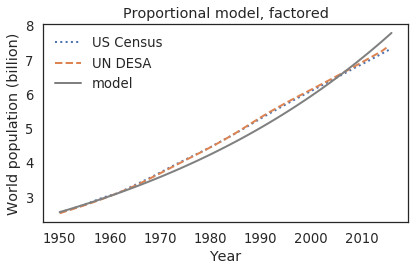

In [18]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [19]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

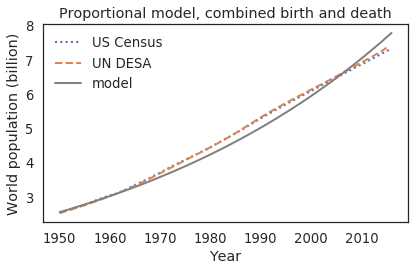

In [20]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [21]:
########################Initialize system variables##################
t_0 = get_first_label(census)
t_end = get_last_label(census) + 20
p_0 = census[t_0]
growth_boundary_year = 1980      #Year that growth rate changes
alpha1 = 0.019                   #Growth rate before boundary year
alpha2 = 0.014                   #Growth rate after boundary year

######################Instantiate system object######################
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                growth_boundary_year=growth_boundary_year,
                alpha1=alpha1,
                alpha2=alpha2)

####################Update function##################################
def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """

    ##################Sub: get growth rate############################
    def get_growth_rate(pop, t, system):
        """Get the population growth rate.
        pop: current population
        t: current year
        system: system object containing parameters of the model
    
        returns: population growth rate
        """
        if t < system.growth_boundary_year:
            result = system.alpha1
        else:
            result = system.alpha2
            
        return result
    
    growth = get_growth_rate(pop, t, system) * pop
    
    return pop + growth

In [22]:
#Test: Expected results = 1 + pre-1980 rate.
update_func3(1, 1950, system)

1.019

In [23]:
#Test: Expected results = 1 + post-1980 rate.
update_func3(1, 1980, system)

1.014

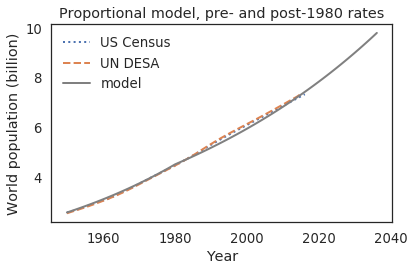

In [24]:
results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, pre- and post-1980 rates')

## Conclusion
The rates I picked for before and after 1980 achieved a fit closer to the data of the US Census and the UN during the period observed. However, extrapolating a 20-year prediction of population beyond the period of data collection still appears to deviate from the expected trend. The proportional approach appears inadequate. The rate of change, itself changes.

## Questions
- Would some kind of spline function find the fit better?
- Even with the model as it is, couldn't I quantify the error and let the simulation optimize the growth rates?

## Sweep the growth rates
I want to quantify the error between the model and the data. Write a routine to sweep the population growth rate before 1980 and after. Quantify the residuals and compare them in a SweepSeries. I have more confidence in this approach than picking variables by trial and error.

In [25]:
# Here is how you reference a pandas Series by a range of labels.
census.loc[1950:1960]

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
1955    2.782099
1956    2.835300
1957    2.891350
1958    2.948137
1959    3.000717
1960    3.043002
Name: census, dtype: float64

### Sweep `alpha1` first

In [26]:
####################### INITIALIZE SYSTEM VARIABLES #######################
# SWEEP ALPHA1
# END WITH 1979
t_0 = get_first_label(census)
t_end = 1979
p_0 = census[t_0]
growth_boundary_year = 1980                                   #Year that growth rate changes
alpha1_array = linrange(0.010, 0.030, 0.001, endpoint = True) #Sweep values for alpha1
alpha2 = 0.014                                                #Growth rate after boundary year

########################## INSTANTIATE SYSTEM OBJECT ######################
# OMIT ALPHA1
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                growth_boundary_year=growth_boundary_year,
                alpha1=None,
                alpha2=alpha2)

########################## SWEEP & RUN SIMULATION #########################
def sweep_alpha1(alpha1_array, system):
    """Execute a simulation, sweeping the alpha1 population growth rate.
    alpha1_array: sweep values for alpha1 variable
    system: system object containing parameters of the model
    
    returns: total squared error
    """

    error_tots = SweepSeries()
    
    for alpha1 in alpha1_array:                                                         #Run simulation
        system.alpha1 = alpha1
        results = run_simulation(system, update_func3)
        error_tots[alpha1] = sum(abs(results - census.loc[system.t_0:system.t_end])**2) #Record the error
    
    return error_tots

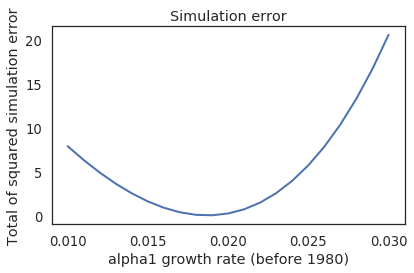

In [27]:
error_tots = sweep_alpha1(alpha1_array, system)       #Run simluation for many alpha1 values, record error

plot(error_tots)                                      #Plot error and view minimum
decorate(title='Simulation error',
         xlabel='alpha1 growth rate (before 1980)', 
         ylabel='Total of squared simulation error')

In [28]:
error_tots[error_tots == error_tots.min()] #Pick off the minimum error and its alpha1 value.

0.019    0.02915
dtype: float64

## alpha1
The optimal value for `alpha1` is: 0.019

### Sweep `alpha2`

In [29]:
####################### INITIALIZE SYSTEM VARIABLES #######################
# SWEEP ALPHA2
# 1980 to latest observation
t_0 = 1980
t_end = get_last_label(census)
p_0 = census[t_0]
growth_boundary_year = 1980                                   #Year that growth rate changes
alpha1 = 0.019                                                #Growth rate before boundary year
alpha2_array = linrange(0.005, 0.025, 0.001, endpoint = True) #Sweep values for alpha2

########################## INSTANTIATE SYSTEM OBJECT ######################
# OMIT ALPHA2
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                growth_boundary_year=growth_boundary_year,
                alpha1=alpha1,
                alpha2=None)

########################## SWEEP & RUN SIMULATION #########################
def sweep_alpha2(alpha2_array, system):
    """Execute a simulation, sweeping the alpha2 population growth rate.
    alpha2_array: sweep values for alpha2 variable
    system: system object containing parameters of the model
    
    returns: total squared error
    """

    error_tots = SweepSeries()
    
    for alpha2 in alpha2_array:                                                         #Run simulation
        system.alpha2 = alpha2
        results = run_simulation(system, update_func3)
        error_tots[alpha2] = sum(abs(results - census.loc[system.t_0:system.t_end])**2) #Record error
    
    return error_tots

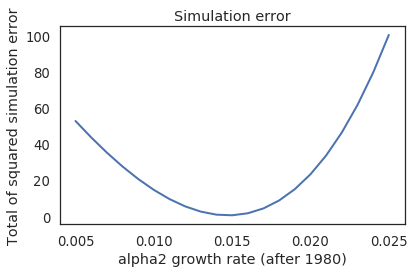

In [30]:
error_tots = sweep_alpha2(alpha2_array, system)       #Run simluation for many alpha1 values, record error

plot(error_tots)                                      #Plot error and view minimum
decorate(title='Simulation error',
         xlabel='alpha2 growth rate (after 1980)', 
         ylabel='Total of squared simulation error')

In [31]:
error_tots[error_tots == error_tots.min()] #Pick off the minimum error and its alpha1 value.

0.015    0.506367
dtype: float64

## alpha2
The optimal value for `alpha2` is: 0.015

## One more time, with feeling
Optimization with eyeballs found the best value for `alpha1`, but I was off by 0.001 for `alpha2`. Now I know I can optimize the variables with simulation itself. Now, I repeat Allen's simulation with the optimized `alpha` variables.

In [32]:
########################Initialize system variables##################
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]
growth_boundary_year = 1980      #Year that growth rate changes
alpha1 = 0.019                   #Growth rate before boundary year
alpha2 = 0.015                   #Growth rate after boundary year

######################Instantiate system object######################
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                growth_boundary_year=growth_boundary_year,
                alpha1=alpha1,
                alpha2=alpha2)


,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
growth_boundary_year,1980.000000
alpha1,0.019000
alpha2,0.015000


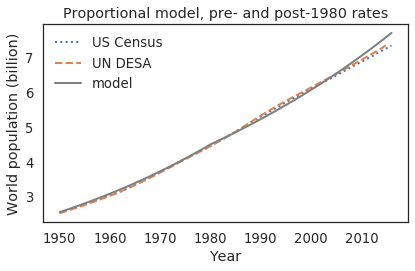

In [33]:
results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, pre- and post-1980 rates')

## Conclusion - part deux
I still think the residuals after 2010 don't look so good, but this was a pretty fun exercise finding the best parameters programmatically within the boundaries of the assignment.